<font color='red'>QUABOUL Dorian - 3872944</font><br>
<font color='red'>IKHLEF MOUHAMAD - 3870476</font>

# Traitement Automatique de la Langue

## Tâche 1 : détection d'auteur, Chirac/Miterrand

_Import de librairies_

In [1]:
import codecs
import re
import string
from wordcloud import WordCloud
import time
import unicodedata
import numpy as np

import spacy
nlp = spacy.load("fr_core_news_sm")

import sklearn
import sklearn.naive_bayes as bayes
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import svm, linear_model as lin
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.snowball import FrenchStemmer

_Liens utiles_

##### Chargement des données
- http://www-connex.lip6.fr/~guigue/wikihomepage/pmwiki.php?n=Course.CourseTALTME3bow

##### Nettoyage, analyse des données textuelles
- https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4854971-nettoyez-et-normalisez-les-donnees
    
    

### Lectures des données utilisées

In [2]:
def read_file(fn):
    with codecs.open(fn,encoding="utf-8") as f:
        return f.read()

In [3]:
def compteLignes(fname):
    count = 0
    with open(fname, 'r') as f:
        for line in f:
            count += 1
    return count

In [4]:
fname_train = "data/corpus.tache1.learn.utf8"
fname_test = "data/corpus.tache1.test.utf8"
file_train = codecs.open(fname_train,"r",encoding="utf-8")
file_test = codecs.open(fname_test,"r",encoding="utf-8")

In [5]:
n_train = compteLignes(fname_train)
n_test = compteLignes(fname_test)
print("Nombre de lignes pour le corpus de train = %d"%n_train)
print("Nombre de lignes pour le corpus de test = %d"%n_test)

Nombre de lignes pour le corpus de train = 57413
Nombre de lignes pour le corpus de test = 27162


In [6]:
def extract_labels_txt(corpus,n_lines):
    alltxts = []
    labels = np.ones(n_lines)
    
    for i in range(n_lines):
        line = corpus.readline()

        label = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",line)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",line)

        if label.count('M') > 0:
            labels[i] = -1
        
        alltxts.append(txt)

    return labels,alltxts

In [7]:
labels_train, corpus_train = extract_labels_txt(file_train,n_train)
labels_test, corpus_test = extract_labels_txt(file_test,n_test)

### NLP Preprocessing

In [8]:
txt = corpus_train[500]
print(txt)
print("-----")
print("NOMBRE DE TOKENS = ",len(txt.split()))

 Elle s'est très sérieusement relevée et le nombre de chefs d'entreprise, grandes, petites et moyennes, qui m'accompagnent, est un témoignage.

-----
NOMBRE DE TOKENS =  20


#### [ETAPE 1] Text Normalization/Cleaning

In [9]:
def text_normalization(s):
    # source : http://www-connex.lip6.fr/~guigue/wikihomepage/pmwiki.php?n=Course.CourseTALTME3pp
    
    # elimination tabulations et retours à la ligne
    s = re.sub("\s"," ",re.sub("\s(?=\s)"," ",s))
    # elimination des ponctuations
    punc = string.punctuation
    s = s.translate(str.maketrans(punc, ' ' * len(punc)))
    # elimination des chiffres
    s = re.sub('\d+', '', s)
    # elimination des espaces multiples
    s = re.sub(' +', ' ', s)
    # elimination des espaces au debut et à la fin
    s = s.strip()
    # texte en minuscule
    s = s.lower()

    return s

In [10]:
step_1 = text_normalization(txt)
print(step_1)
print("-----")
print("NOMBRE DE TOKENS = ",len(step_1.split()))

elle s est très sérieusement relevée et le nombre de chefs d entreprise grandes petites et moyennes qui m accompagnent est un témoignage
-----
NOMBRE DE TOKENS =  23


#### POS Tagging

In [11]:
def postagging(s):
    print([w.pos_ for w in nlp(s)])
    print([w.text for w in nlp(s)])

In [12]:
postagging(step_1)

['PRON', 'PRON', 'AUX', 'ADV', 'ADV', 'VERB', 'CCONJ', 'DET', 'NOUN', 'ADP', 'NOUN', 'NOUN', 'NOUN', 'ADJ', 'ADJ', 'CCONJ', 'NOUN', 'PRON', 'NOUN', 'VERB', 'AUX', 'DET', 'NOUN']
['elle', 's', 'est', 'très', 'sérieusement', 'relevée', 'et', 'le', 'nombre', 'de', 'chefs', 'd', 'entreprise', 'grandes', 'petites', 'et', 'moyennes', 'qui', 'm', 'accompagnent', 'est', 'un', 'témoignage']


#### [ETAPE 2] Suppresion des Stopwords

In [13]:
def delete_stopwords(s,stopwords) :
    tokens = nlp(s)
    return " ".join([w.text for w in tokens if w.text not in stopwords])

In [14]:
stopwords_fr = read_file("data/stopwords_french.txt").split("\r\n")
print("Liste des "+str(len(stopwords_fr))+" stopwords français :\n",stopwords_fr)

Liste des 691 stopwords français :
 ['a', 'abord', 'absolument', 'afin', 'ah', 'ai', 'aie', 'aient', 'aies', 'ailleurs', 'ainsi', 'ait', 'allaient', 'allo', 'allons', 'allô', 'alors', 'anterieur', 'anterieure', 'anterieures', 'apres', 'après', 'as', 'assez', 'attendu', 'au', 'aucun', 'aucune', 'aucuns', 'aujourd', "aujourd'hui", 'aupres', 'auquel', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aussi', 'autant', 'autre', 'autrefois', 'autrement', 'autres', 'autrui', 'aux', 'auxquelles', 'auxquels', 'avaient', 'avais', 'avait', 'avant', 'avec', 'avez', 'aviez', 'avions', 'avoir', 'avons', 'ayant', 'ayez', 'ayons', 'b', 'bah', 'bas', 'basee', 'bat', 'beau', 'beaucoup', 'bien', 'bigre', 'bon', 'boum', 'bravo', 'brrr', 'c', 'car', 'ce', 'ceci', 'cela', 'celle', 'celle-ci', 'celle-là', 'celles', 'celles-ci', 'celles-là', 'celui', 'celui-ci', 'celui-là', 'celà', 'cent', 'cependant', 'certain', 'certaine', 'certaines', 'certains', 

In [15]:
step_2 = delete_stopwords(step_1, stopwords_fr)
print(step_2)
print("-----")
print("NOMBRE DE TOKENS = ",len(step_2.split()))

sérieusement relevée nombre chefs entreprise grandes petites moyennes accompagnent témoignage
-----
NOMBRE DE TOKENS =  10


#### [ETAPE 3] Stemmatisation

In [16]:
def stemmatisation(s) :
    stemmer = FrenchStemmer()
    words = []
    
    for w in s.split(" ") :
        if w != "" :
            words.append(stemmer.stem(w))
    
    new_s = ' '.join(words)

    return new_s

In [17]:
step_3 = stemmatisation(step_2)
print(step_3)
print("-----")
print("NOMBRE DE TOKENS = ",len(step_3.split()))

sérieux relev nombr chef entrepris grand petit moyen accompagnent témoignag
-----
NOMBRE DE TOKENS =  10


#### Pipeline du preprocessing

In [18]:
def preprocessing(s, option1, stopwords):
    if option1 == "stema" :
        if stopwords :
            return stemmatisation(delete_stopwords(text_normalization(s),stopwords))
        else :
            return stemmatisation(text_normalization(s))
    else :
        if stopwords :
            return delete_stopwords(text_normalization(s),stopwords)
        else :
            return text_normalization(s)

### Exploration et analyse de la matrice Document-Term

#### Construction des différents corpus

In [19]:
# On garde les stopwords
corpus_ = [preprocessing(d,"none",None) for d in corpus_train]
corpus_stema = [preprocessing(d,"stema",None) for d in corpus_train]
# On supprime les stopwords
corpus_sw = [preprocessing(d,"none",stopwords_fr) for d in corpus_train]
corpus_sw_stema = [preprocessing(d,"stema",stopwords_fr) for d in corpus_train]

all_corpus = [[corpus_, corpus_stema],
              [corpus_sw, corpus_sw_stema]]

#### [ETAPE 4] CountVectorizer

![Représentation en une matrice sparse](img/sparse_matrix_corpus.png)

In [20]:
vectorizer = CountVectorizer(max_df=0.85, min_df=0.0001)
X = vectorizer.fit_transform(corpus_sw_stema)

In [21]:
vocab = np.array(vectorizer.get_feature_names())

print("Nombre de mots dans le vocabulaire : ", len(vocab))
print("30 mots du vocabulaire : ", vocab[3000:3030])

Nombre de mots dans le vocabulaire :  5176
30 mots du vocabulaire :  ['mutual' 'mutuel' 'my' 'myster' 'mystéri' 'myth' 'mènent' 'mécan' 'mécen'
 'méconnaiss' 'méconnaîtr' 'méconnu' 'mécénat' 'médaill' 'médecin' 'médi'
 'médiat' 'médiateur' 'médic' 'médical' 'médit' 'méditerran'
 'méditerranéen' 'méfianc' 'mélancol' 'mélang' 'mémoir' 'mémorandum'
 'mémorial' 'ménag']


Text(0.5, 1.0, 'les 20 mots les moins fréquents')

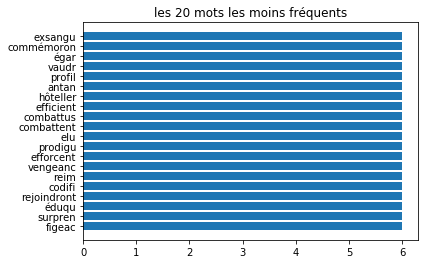

In [22]:
tf = X.toarray().sum(0)
n = 20
ind = tf.argsort()[:n]
plt.barh(vocab[ind], tf[ind])
plt.title("les "+str(n)+" mots les moins fréquents")

Text(0.5, 1.0, 'les 20 mots les plus fréquents')

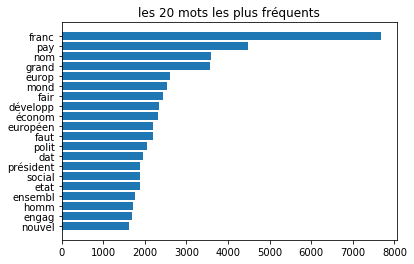

In [23]:
ind = tf.argsort()[-n:]
plt.barh(vocab[ind], tf[ind])
plt.title("les "+str(n)+" mots les plus fréquents")

**WordCloud : Les 10 mots les plus utilisés par président**

In [24]:
def generate_wordcloud(words, president) : 
    
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',  
                min_font_size = 10).generate(words) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.title("Les 15 mots les plus utilisés par "+president)
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

In [25]:
ind_C = np.where(labels_train == 1)
ind_M = np.where(labels_train == -1)

tf_C = X.toarray()[ind_C][:].sum(0)
tf_M = X.toarray()[ind_M][:].sum(0)

ind_mots_C = tf_C.argsort()[-15:]
ind_mots_M = tf_M.argsort()[-15:]

mots_C = vocab[ind_mots_C]
mots_M = vocab[ind_mots_M]

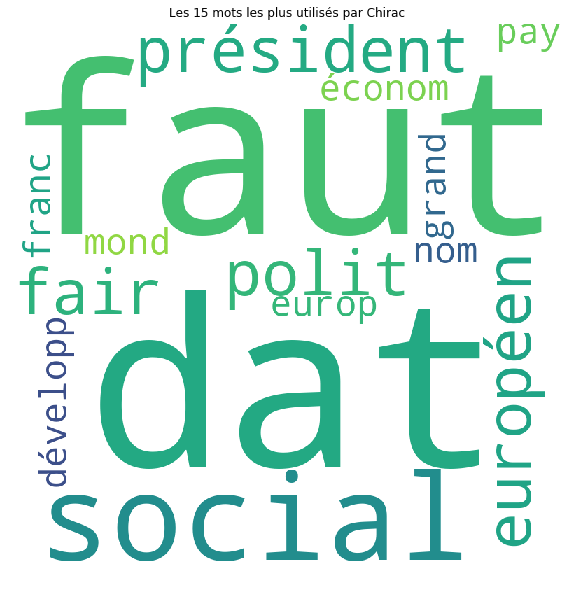

In [26]:
generate_wordcloud(" ".join(mots_C), "Chirac")

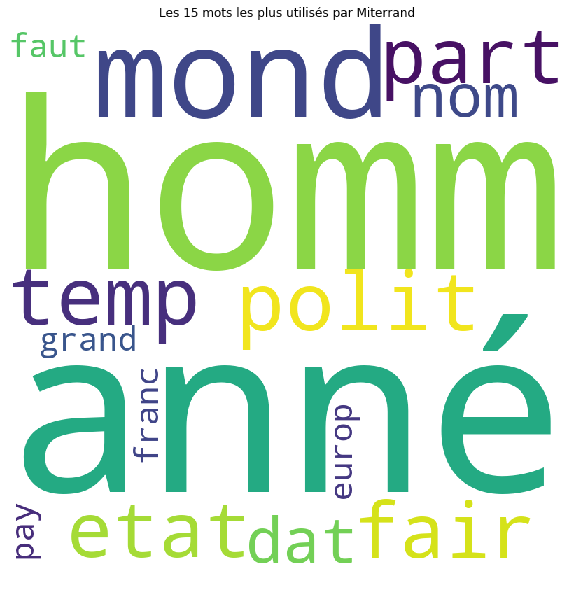

In [27]:
generate_wordcloud(" ".join(mots_M),"Miterrand")

### Optimisation des hyper-paramètres des modèles

In [36]:
def findBestHyperParam(name_clf, X_train, y_train,):
    if name_clf == "[reg_logistic]" :
        
        logistic = lin.LogisticRegression()

        param_grid = {'penalty':['l1', 'l2'],
                      'C':[0.1, 1, 10, 100],
                      'solver':['liblinear', 'saga']}

        grid = GridSearchCV(estimator=logistic,
                            param_grid=param_grid,
                            scoring='f1',
                            verbose=1,
                            n_jobs=-1,
                            cv = 5)
        
        grid_result = grid.fit(X_train, y_train)

        print('Best Score: ', grid_result.best_score_)
        print('Best Params: ', grid_result.best_params_)
        
        return grid_result.best_estimator_
    
    elif name_clf == "[bayes]" :
        
        multi_nb = bayes.MultinomialNB()
        
        param_grid = {'alpha': [0,0.1,1,10,100]}
        
        grid = GridSearchCV(estimator=multi_nb,
                            param_grid=param_grid,
                            scoring='f1',
                            verbose=1,
                            n_jobs=-1,
                            cv = 5)
        
        grid_result = grid.fit(X_train, y_train)
        
        print('Best Score: ', grid_result.best_score_)
        print('Best Params: ', grid_result.best_params_)
        
        return grid_result.best_estimator_
        
    elif name_clf == "[svm]" :
        
        svc = svm.SVC()
        
        param_grid = {'C': [0.1,1, 10, 100], 
                      'gamma': [1,0.1,0.01,0.001],
                      'kernel': ['rbf', 'poly', 'sigmoid']}
        
        grid = GridSearchCV(estimator=svc,
                            param_grid=param_grid,
                            scoring='f1',
                            verbose=1,
                            n_jobs=-1,
                            cv = 5)
        
        grid_result = grid.fit(X_train, y_train)
        
        print('Best Score: ', grid_result.best_score_)
        print('Best Params: ', grid_result.best_params_)
        
        return grid_result.best_estimator_
    else :
        print("Le nom du modèle ne comvient pas pour cette fonction !")

In [29]:
best_multinb = findBestHyperParam("[bayes]", X, labels_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Score:  0.9299035390353548
Best Params:  {'alpha': 100}


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.1s finished


In [37]:
n_max = 10000
best_svm = findBestHyperParam("[svm]", X[:n_max], labels_train[:n_max])

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  6.6min finished


Best Score:  0.9011016283875497
Best Params:  {'C': 10, 'gamma': 0.01, 'kernel': 'sigmoid'}


Source : https://datascience.stackexchange.com/questions/64958/why-svm-gridsearch-takes-longer-time

In [30]:
best_reg_logistic = findBestHyperParam("[reg_logistic]", X, labels_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  6.6min finished


Best Score:  0.9373871789096819
Best Params:  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


## Campagne d'évaluation et comparaison de 3 modèles de classification

Cette campagne d'évaluation va consister à choisir les meilleurs paramètres pour déterminer la classe d'un avis.

Les paramètres qui seront modulés :
- avec ou sans Stopwords
- Unigram/Bigram/Trigram
- Stemmatisation

In [38]:
def campagne_evaluation(corpus, labels, stop_words, ngram, classifieur, clf):

    tic = time.perf_counter() 
    
    ordinates = [[] for i in range(8)]
    abscissas = [[] for i in range(8)]
    cpt = 0

    for tab in corpus :
        for c in tab :
            abscissas[cpt] = np.linspace(20, get_len_vocab(c, ngram), 20, dtype = int)
            abscissas[cpt+1] = np.linspace(20, get_len_vocab(c, ngram), 20, dtype = int)
            for step in abscissas[cpt]:
                vectorizer = CountVectorizer(max_features=step, ngram_range=(1,ngram), max_df=0.85, min_df=0.0001)
                tf_idf = TfidfVectorizer(max_features=step, ngram_range=(1,ngram), max_df=0.85, min_df=0.0001)
                X_v = vectorizer.fit_transform(c)
                X_t = tf_idf.fit_transform(c)
                ordinates[cpt].append(cross_validation(clf, X_v, labels))
                ordinates[cpt+1].append(cross_validation(clf, X_t, labels))
            cpt+=2
             
    print("Temps d'éxécution : "+str(round(time.perf_counter()-tic, 2))+" secondes")
    
    labels = ['TF','TFIDF', 
              'TF-STEMA','TFIDF-STEMA',
              'TF-STPW','TFIDF-STPW',
              'TF-STPW-STEMA','TFIDF-STPW-STEMA']
    
    for j in range(8) :
        plt.plot(abscissas[j], ordinates[j], label=labels[j])
        plt.legend()
        
    plt.title(classifieur + " - F1-score en fonction du nb de mots conservés : "+mot_gram(ngram))
    plt.xlabel("Nombre de mots conservés")
    plt.ylabel("F1-score")
    plt.show()
    
    ind = [np.argmax(o) for o in ordinates]
    max_gram = [abscissas[_][ind[_]] for _ in range(8)] 

    for _ in range(8):
        print("Meilleur score <"+str(ordinates[_][ind[_]])+"> pour",labels[_],"avec "+(str(max_gram[_]))+" "+mot_gram(ngram))

    return max_gram

In [39]:
def cross_validation(clf, X, y, n_splits=5):
    scores = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        scores.append(f1_score(y_test,clf.predict(X_test)))
        
    return sum(scores)/n_splits

In [40]:
def get_len_vocab(corpus, ngram):
    vectorizer = CountVectorizer(max_df=0.85, min_df=0.0001, ngram_range = (1,ngram))
    vectorizer.fit_transform(corpus)
    return len(vectorizer.get_feature_names())

In [41]:
def mot_gram(ngram):
    if ngram == 1:
        return "unigrams"
    elif ngram == 2:
        return "bigrams"
    elif ngram == 3:
        return "trigrams"
    else:
        return "ngrams"

#### 1-SVM

<font color='red'>/!\ A NOTER /!\\</font><br><br>
<font color='red'>Nous avons été dans l'impossibilité de lancer une campagne d'évaluation sur le SVM car le temps d'exécution était beaucoup trop long (toute une nuit à tourner, mais rien ne se passait)</font>

UNIGRAM

In [ ]:
svm1 = campagne_evaluation(all_corpus, labels_train, stopwords_fr, 1, "[SVM]",best_svm)

BIGRAM

In [ ]:
svm2 = campagne_evaluation(all_corpus, labels_train, stopwords_fr, 2, "[SVM]", best_svm)

#### 2- Naive Bayes

UNIGRAM

Temps d'éxécution : 175.55 secondes


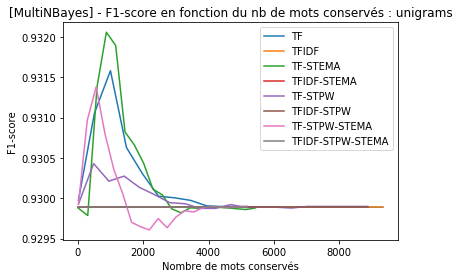

Meilleur score <0.931580748180942> pour TF avec 1000 unigrams
Meilleur score <0.9298901247122318> pour TFIDF avec 20 unigrams
Meilleur score <0.932057031027172> pour TF-STEMA avec 875 unigrams
Meilleur score <0.9298901247122318> pour TFIDF-STEMA avec 20 unigrams
Meilleur score <0.9304301729205612> pour TF-STPW avec 486 unigrams
Meilleur score <0.9298901247122318> pour TFIDF-STPW avec 20 unigrams
Meilleur score <0.9313799681888997> pour TF-STPW-STEMA avec 562 unigrams
Meilleur score <0.9298901247122318> pour TFIDF-STPW-STEMA avec 20 unigrams


In [42]:
bayes1 = campagne_evaluation(all_corpus, labels_train, stopwords_fr, 1, "[MultiNBayes]",best_multinb)

BIGRAM

Temps d'éxécution : 477.89 secondes


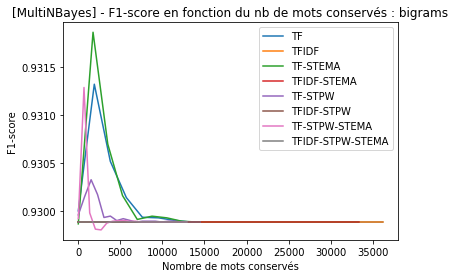

Meilleur score <0.9313186945421081> pour TF avec 1922 bigrams
Meilleur score <0.9298901247122318> pour TFIDF avec 20 bigrams
Meilleur score <0.9318573171953417> pour TF-STEMA avec 1771 bigrams
Meilleur score <0.9298901247122318> pour TFIDF-STEMA avec 20 bigrams
Meilleur score <0.9303284870741741> pour TF-STPW avec 1544 bigrams
Meilleur score <0.9298901247122318> pour TFIDF-STPW avec 20 bigrams
Meilleur score <0.9312846368362809> pour TF-STPW-STEMA avec 697 bigrams
Meilleur score <0.9298901247122318> pour TFIDF-STPW-STEMA avec 20 bigrams


In [44]:
bayes2 = campagne_evaluation(all_corpus, labels_train, stopwords_fr, 2, "[MultiNBayes]",best_multinb)

#### 3- Régression Logistique

UNIGRAM

Temps d'éxécution : 308.95 secondes


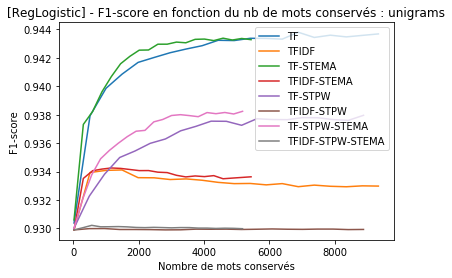

Meilleur score <0.9438050539713151> pour TF avec 6880 unigrams
Meilleur score <0.9341102836498767> pour TFIDF avec 1490 unigrams
Meilleur score <0.9433871678575938> pour TF-STEMA avec 4580 unigrams
Meilleur score <0.9342509053905637> pour TFIDF-STEMA avec 1160 unigrams
Meilleur score <0.9379575731712444> pour TF-STPW avec 8876 unigrams
Meilleur score <0.9299862982297868> pour TFIDF-STPW avec 952 unigrams
Meilleur score <0.9382388813969422> pour TF-STPW-STEMA avec 5176 unigrams
Meilleur score <0.9302126209246266> pour TFIDF-STPW-STEMA avec 562 unigrams


In [45]:
lin1 = campagne_evaluation(all_corpus, labels_train, stopwords_fr, 1, "[RegLogistic]",best_reg_logistic)

BIGRAM

Temps d'éxécution : 683.35 secondes


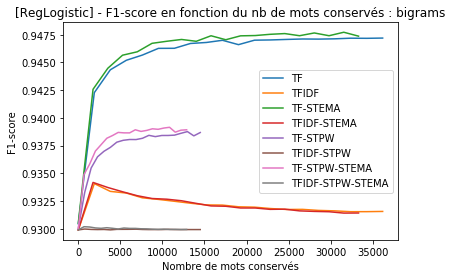

Meilleur score <0.9471953677854215> pour TF avec 36167 bigrams
Meilleur score <0.9340673311652145> pour TFIDF avec 1922 bigrams
Meilleur score <0.9477205639408975> pour TF-STEMA avec 31551 bigrams
Meilleur score <0.9341735357338139> pour TFIDF-STEMA avec 1771 bigrams
Meilleur score <0.938758420824809> pour TF-STPW avec 12979 bigrams
Meilleur score <0.9299702700846266> pour TFIDF-STPW avec 782 bigrams
Meilleur score <0.9391470938519753> pour TF-STPW-STEMA avec 10856 bigrams
Meilleur score <0.9301792267280373> pour TFIDF-STPW-STEMA avec 697 bigrams


In [47]:
lin2 = campagne_evaluation(all_corpus, labels_train, stopwords_fr, 2, "[RegLogistic]",best_reg_logistic)

## Génération des prédictions pour le dataset de test

Selon la campagne d'évaluation, ...

In [122]:
def generate_file_test(predictions,nom_fichier) :
    predict_letter = np.where(predictions == -1, 'M','C')
    
    filename = nom_fichier+".txt"
    
    with open(filename, "w") as f:
        for i in range(len(predict_letter)) :
            if i == len(predict_letter)-1 :
                f.write("%s" % predict_letter[i]) 
            else:
                f.write("%s\n" % predict_letter[i]) 
            
def generate_file_test2(predict_letter,nom_fichier) :
    filename = nom_fichier+".txt"
    
    with open(filename, "w") as f:
        for i in range(len(predict_letter)) :
            if i == len(predict_letter)-1 :
                f.write("%s" % predict_letter[i]) 
            else:
                f.write("%s\n" % predict_letter[i])           

On transforme le corpus de test en matrice sparse à partir des mots du vocabulaire contenus dans le vectorizer

In [51]:
print(corpus_test[0])
corpus_test_stema = [preprocessing(d,"stema",None) for d in corpus_test]
print("-----")
print(corpus_test_stema[0])

<105:1> En répondant à votre invitation, en effectuant cette première visite d'Etat d'un Président français en Algérie depuis l'indépendance, j'ai conscience d'ouvrir avec vous un chapitre nouveau de notre histoire commune, le chapitre de la confiance, de l'estime, du respect mutuel, de l'amitié et de la solidarité.

-----
en répond à votr invit en effectu cet premi visit d etat d un président franc en alger depuis l indépend j ai conscienc d ouvr avec vous un chapitr nouveau de notr histoir commun le chapitr de la confianc de l estim du respect mutuel de l amiti et de la solidar


In [52]:
best_vectorizer = CountVectorizer(max_features=lin2[2], ngram_range=(1,2), max_df=0.85, min_df=0.0001)
X_train = best_vectorizer.fit_transform(corpus_stema)
best_reg_logistic.fit(X_train,labels_train)

corpus_test_stema = [preprocessing(d,"stema",None) for d in corpus_test]

X_test = best_vectorizer.transform(corpus_test_stema)
predictions = best_reg_logistic.predict(X_test)

In [123]:
generate_file_test(predictions,"predictions_reglogistic_tf_stema_bigram")

In [118]:
print("Sans Post Processing")
print("Number of M in predictions :",np.sum(np.where(predictions == -1,1,0)))
print("Number of C in predictions :",np.sum(np.where(predictions == 1,1,0)))

Sans Post Processing
Number of M in predictions : 1644
Number of C in predictions : 25518


### Post Processing 

In [109]:
def post_processing(predictions_letter) :

    predictions_letter_lissag1 = predictions_letter.copy()
    
    for i in range(5, len(predictions_letter)-5):
               
        
        fivebefore = predictions_letter[i-5:i]
        fiveafter = predictions_letter[i+1:i+6]
        
        countM = np.sum(np.where(fivebefore == 'M',1,0))*2.85 + np.sum(np.where(fiveafter == 'M',1,0))*2.85
        countC = np.sum(np.where(fivebefore == 'C',1,0))*1 + np.sum(np.where(fiveafter == 'C',1,0))*1

        if countM > countC :
            predictions_letter_lissag1[i] = 'M'
        elif countM < countC :
            predictions_letter_lissag1[i] = 'C'
        else :
            pass
        
    return predictions_letter_lissag1

In [113]:
test = np.array(["C","C","C","C","M","C","C","M","M","C","C","C","C","C","C","C","C"])
print("Avant lissage")
print(test)
print("Après lissage x 1")
print(post_processing(test))
print("Après lissage x 2")
print(post_processing(post_processing(test)))

Avant lissage
['C' 'C' 'C' 'C' 'M' 'C' 'C' 'M' 'M' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C']
Après lissage x 1
['C' 'C' 'C' 'C' 'M' 'M' 'M' 'C' 'C' 'M' 'C' 'C' 'C' 'C' 'C' 'C' 'C']
Après lissage x 2
['C' 'C' 'C' 'C' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'C' 'C' 'C' 'C' 'C' 'C']


In [114]:
print("Après lissage x 1")
print("Number of M in predictions :",np.sum(np.where(post_processing(predictions_letter) == 'M',1,0)))
print("Number of C in predictions :",np.sum(np.where(post_processing(predictions_letter) == 'C',1,0)))

Après lissage x 1
Number of M in predictions : 2629
Number of C in predictions : 24533


In [115]:
print("Après lissage x 2")
print("Number of M in predictions :",np.sum(np.where(post_processing(post_processing(predictions_letter)) == 'M',1,0)))
print("Number of C in predictions :",np.sum(np.where(post_processing(post_processing(predictions_letter)) == 'C',1,0)))

Après lissage x 2
Number of M in predictions : 3799
Number of C in predictions : 23363


In [125]:
predictions_letter = np.where(predictions == -1, 'M','C')
# Après lissage x2
generate_file_test2(post_processing(post_processing(predictions_letter)),"predictions_reglogistic_tf_stema_bigram_postprocx2")

# Conclusion